In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Split the dataset into training and test sets
train_data, test_data = train_test_split(trainset, test_size=0.2, random_state=42)

# Create data loaders for training and test sets
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

Each picture has 28*28 pixels. 
Intotal 60000 pictures.
Learning rate 0.01, each batch takes 64 pictures. 
How many epochs should we set?

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # print(x.shape)
        x = self.conv1(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.conv2(x)
        # print(x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # print(x.shape)
        x = self.dropout1(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc1(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # print(x.shape)
        output = F.log_softmax(x, dim=1)
        return output

In [22]:
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def train_model(model):
    loss_record = []
    running_loss = 0.0    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            loss_record.append(running_loss / 100)
            running_loss = 0.0
    return loss_record

def test_model(model):
    model.eval()  # Set the model to evaluation mode
    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over the test data
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            _, predicted = torch.max(model(inputs), 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Compute metrics
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    #print('Confusion Matrix:')
    #print(conf_matrix)
    return precision, recall, f1, conf_matrix

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('training models on ', device)
model.to(device)
loss_history = []
metric_history = []
for epoch in range(20):  # loop over the dataset multiple times
    loss_record = train_model(model)
    loss_history.append(loss_record)
    metric_record = test_model(model)
    metric_history.append(metric_record)


training models on  cuda
[Epoch 1, Batch 100] loss: 0.791
[Epoch 1, Batch 200] loss: 0.276
[Epoch 1, Batch 300] loss: 0.203
[Epoch 1, Batch 400] loss: 0.170
[Epoch 1, Batch 500] loss: 0.156
[Epoch 1, Batch 600] loss: 0.151
[Epoch 1, Batch 700] loss: 0.143
Precision: 0.9782
Recall: 0.9776
F1 Score: 0.9778
[Epoch 2, Batch 100] loss: 0.047
[Epoch 2, Batch 200] loss: 0.047
[Epoch 2, Batch 300] loss: 0.047
[Epoch 2, Batch 400] loss: 0.047
[Epoch 2, Batch 500] loss: 0.045
[Epoch 2, Batch 600] loss: 0.041
[Epoch 2, Batch 700] loss: 0.037
Precision: 0.9855
Recall: 0.9854
F1 Score: 0.9854
[Epoch 3, Batch 100] loss: 0.024
[Epoch 3, Batch 200] loss: 0.024
[Epoch 3, Batch 300] loss: 0.024
[Epoch 3, Batch 400] loss: 0.028
[Epoch 3, Batch 500] loss: 0.023
[Epoch 3, Batch 600] loss: 0.032
[Epoch 3, Batch 700] loss: 0.028
Precision: 0.9865
Recall: 0.9867
F1 Score: 0.9865
[Epoch 4, Batch 100] loss: 0.016
[Epoch 4, Batch 200] loss: 0.019
[Epoch 4, Batch 300] loss: 0.019
[Epoch 4, Batch 400] loss: 0.013


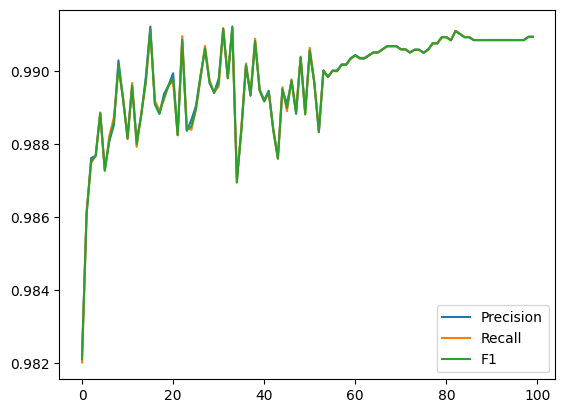

In [47]:
import matplotlib.pyplot as plt
precision = [m[0] for m in metric_history]
recall = [m[1] for m in metric_history]
f1 = [m[2] for m in metric_history]
plt.plot(precision, label='Precision')
plt.plot(recall, label='Recall')
plt.plot(f1, label='F1')
plt.legend(['Precision', 'Recall', 'F1'])